In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import torch
from torch import nn, optim

In [2]:
from tqdm.notebook import tqdm

In [3]:
import torch.nn.functional as F

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
dataset_train = list()


# 1. Train Data Pairs
with open('train_job/train.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):

        if i == 0:
            pass
        else:
            dataset_train.append([line[0], line[1], int(line[2])])

# 2. Job id to number/ Job tags

job_dict = dict()

with open('train_job/job_tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i == 0:
            pass
        else:
            try:
                job_dict[line[0]].append(line[1])
            except KeyError:
                job_dict[line[0]] = [line[1]]
                
# 3. Job id to company code and size. Not using right now
                
company_set = set()
jobs_set = set()
company_size_set = set()

with open('train_job/job_companies.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i == 0:
            pass
#             print(line)
        else:
            company_set.add(line[0])
            jobs_set.add(line[1])
            company_size_set.add(line[2])

# 4. User skills
            
user_dict = dict()

with open('train_job/user_tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i != 0:
    
            try:
                user_dict[line[0]].append(line[1])
            except KeyError:
                user_dict[line[0]] = [line[1]]

# 5. Job required skills
                
tag_dictionary = dict()
tag_idx_to_tag_list = list()

with open('train_job/tags.csv', 'r') as f:
    csv_reader = csv.reader(f)
    
    for i, line in enumerate(csv_reader):
        
        if i != 0:
            tag_dictionary[line[0]] = i - 1
            tag_idx_to_tag_list.append(line)
            assert len(tag_idx_to_tag_list) == i
    
def tagID2Vector(tag_list):
    vector = np.zeros(len(tag_dictionary))
    
    for tag in tag_list:
        vector[tag_dictionary[tag]] = 1
    
    return vector

def jobID2Vector(job_id):
    vector = np.zeros(len(tag_dictionary))
    for tag in job_dict[job_id]:
        vector[tag_dictionary[tag]] = 1
    assert np.sum(vector) == len(job_dict[job_id]), f'{np.sum(vector)} != {len(job_dict[job_id])}'
    return vector

In [6]:
for job in job_dict:
    assert len(job_dict[job]) == len(set(job_dict[job]))

In [7]:
def collate_function(data_input):

    global user_dict
    
    person_id_list = list()
    job_id_list = list()
    answer = list()

    for data in data_input:
        person_id_list.append(data[0])
        job_id_list.append(data[1])
        answer.append(data[2])
    
    person_tensor = list()
    for person_id in person_id_list:
        user_skill_set = set(user_dict[person_id])
        vector = tagID2Vector(user_skill_set)
        person_tensor.append(vector)
        
    job_tensor = list()
    for job_id in job_id_list:
        vector = jobID2Vector(job_id)
        job_tensor.append(vector)
        
    answer_tensor = torch.tensor(answer)
        
    return torch.tensor(person_tensor), torch.tensor(job_tensor), answer_tensor

In [8]:
dataloader = DataLoader(dataset_train, 
                        batch_size=4, 
                        shuffle=True, 
                        num_workers=4, 
                        collate_fn=collate_function)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(887 * 3, 2 ** 11), 
                                     nn.Linear(2 ** 11, 2 ** 11), 
                                     nn.Linear(2 ** 11, 2 ** 11), 
                                     nn.Linear(2 ** 11, 2 ** 11), 
                                     nn.Linear(2 ** 11, 2 ** 10), 
                                     nn.Linear(2 ** 10, 2 ** 9),
                                     nn.Linear(2 ** 9, 2 ** 8),
                                     nn.Linear(2 ** 8, 2 ** 7),
                                     nn.Linear(2 ** 7, 2 ** 6),
                                     nn.Linear(2 ** 6, 2 ** 5),
                                     nn.Linear(2 ** 5, 2 ** 4),
                                     nn.Linear(2 ** 4, 2 ** 3),
                                     nn.Linear(2 ** 3, 2 ** 2),
                                     nn.Linear(2 ** 2, 2 ** 1),
                                    ])
        
        self.last_layer = nn.Linear(2 ** 1, 2 ** 1)

    def forward(self, tensor):
        
        for layer in self.layers:
            tensor = F.relu(layer(tensor))
#             tensor = layer(tensor)
        
        tensor = self.last_layer(tensor)
        
        tensor = F.sigmoid(tensor)
        
        return tensor


In [10]:
list_t = [[0.1, 0.5],
         [0.2, 0.5],
         [0.5, 0.5],
         [0.5, 0.5]]

In [11]:
def accuracy(pred, label):
    
    assert len(pred) == len(label)
    
#     pred_label = np.floor(pred + 0.5)
    
    acc = 0
    
#     print(pred, label)
    
#     for i in range(len(pred)):
#         if pred_label[i] == label[i]:
#             acc += 1

#     return acc / len(pred_label)

    label_pred = [np.argmax(elem) for elem in pred]
    
    for i in range(len(pred)):
        if label_pred[i] == label[i]:
            acc += 1
            
    return acc / len(label_pred)

/Users/joowhan/opt/anaconda3/envs/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/joowhan/opt/anaconda3/envs/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/joowhan/opt/anaconda3/envs/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/joowhan/opt/anaconda3/envs/py3_env/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functiona

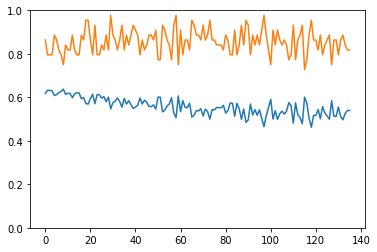

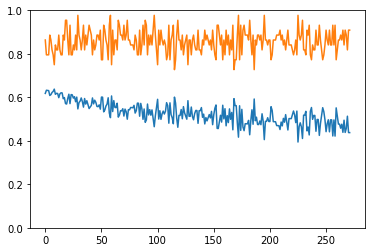

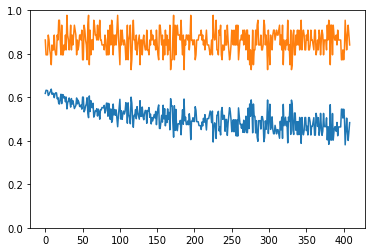

In [ ]:


# 모델 초기화
model = Net()

# 옵티마이저 초기화
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

loss_history = list()
acc_history = list()

running_loss = list()
running_acc = list()

for i in range(60):

    for i, (p_tensor, j_tensor, a_tensor) in tqdm(enumerate(dataloader)):

    #     print(i)
    #     print(p_tensor.shape)
    #     print(j_tensor.shape)
    #     print(a_tensor.shape)

        p_tensor = torch.tensor(p_tensor, dtype=torch.float32)
        j_tensor = torch.tensor(j_tensor, dtype=torch.float32)
        a_tensor = torch.tensor(a_tensor, dtype=torch.int64)

        s_tensor = torch.clamp(j_tensor - p_tensor, 0, 1)

        input_tensor = torch.cat((p_tensor, j_tensor, s_tensor), 1)

        model.zero_grad()

        pred_tensor = model(input_tensor)

    #     pred_tensor = torch.tensor(pred_tensor, dtype=torch.float64)

    #     print(pred_tensor.dtype)
    #     print(a_tensor.dtype)

        loss = criterion(pred_tensor, a_tensor)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        running_acc.append(accuracy(pred_tensor.detach().numpy(), 
                           a_tensor.detach().numpy()))
        
        if len(running_loss) > 10:
            loss_history.append(np.mean(running_loss))
            acc_history.append(np.mean(running_acc))
            running_loss = list()
            running_acc = list()
    
    plt.figure()
    plt.plot(loss_history)
    plt.plot(acc_history)
    plt.ylim([0, 1])
    plt.show()

In [ ]:
plt.plot(running_loss)

In [ ]:
user_vector_dict = dict()
job_vector_dict = dict()

for user in user_dict:
#     print(user)
    user_skill_set = set(user_dict[user])
    vector = tagID2Vector(user_skill_set)
    assert len(user_skill_set) == np.sum(vector), ''
    
for job in job_dict:
    vector = jobID2Vector(job)
#     print(vector)
#     break
